In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
from sklearn.cluster import DBSCAN
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.signal import periodogram

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import statsmodels

In [3]:
lang_codes = ["ja", "ko", "tr", "sv" , "no", "fi", "da", "sr", "it" , "ca", "nl", "fr", "de"]
ctr_codes = ["JPN", "KOR", "TUR", "SWE", "NOR", "FIN", "DEN", "SER", "ITA", "SPA", "NET", "FRA", "GER"]
code_dict = dict(zip(ctr_codes, lang_codes))
country_region = {'East Asia': ['ja', 'ko'], 'West Asia': ['tr'], 'Northern Europe': ['sv', 'no', 'fi', 'da'],
        'Southern Europe': ['sr', 'it', 'ca'], 'Western Europe':['nl', 'fr', 'de'], 'North America': ['en']}

agg = pd.read_json("data/aggregated_timeseries.json.gz")
hofstede = pd.read_csv("data/6-dimensions-for-website-2015-08-16.csv", sep=";")
hofstede = hofstede[hofstede.ctr.isin(ctr_codes)].set_index('ctr').drop('country', axis=1).astype(int)
hofstede

,pdi,idv,mas,uai,ltowvs,ivr
ctr,,,,,,
DEN,18,74,16,23,35,70
FIN,33,63,26,59,38,57
FRA,68,71,43,86,63,48
GER,35,67,66,65,83,40
ITA,50,76,70,75,61,30
JPN,54,46,95,92,88,42
KOR,60,18,39,85,100,29
NET,38,80,14,53,67,68
NOR,31,69,8,50,35,55


In [38]:
dfs = []

for language in agg:
    language_data = agg[language]

    all_len = language_data['len']
    all_sum = pd.Series(language_data['sum'])

    topics_data = language_data['topics'] # dict with the timeseries of each topic

    if 0 in all_sum.values:
        all_sum.replace(0, 1, inplace=True)
    
    for topic, topic_data in topics_data.items():
        topic_len = topic_data['len'] # number of articles for a topic
        topic_sum = pd.Series(topic_data['sum']) # number of pageviews per day for a topic

        topic_df = pd.DataFrame({
            'pageviews': topic_sum.values,
            'pageviews_per_page' : topic_sum.values/topic_len,
            'language': [language] * len(topic_sum),
            'date': topic_sum.index,
            'topic': [topic] * len(topic_sum),
            'proportion': np.divide(topic_sum.values, all_sum.values)
        })

        dfs.append(topic_df)
    
    all_df = pd.DataFrame({
        'pageviews': all_sum.values,
        'pageviews_per_page' : all_sum.values/all_len,
        'language': [language] * len(all_sum),
        'date': all_sum.index,
        'topic': ['ALL'] * len(all_sum),
        'proportion': 1
    })
    dfs.append(all_df)
df_timeseries = pd.concat(dfs, ignore_index=True)
df_timeseries.date = pd.to_datetime(df_timeseries.date)
display(df_timeseries)

,pageviews,pageviews_per_page,language,date,topic,proportion
0,6629234,44.478966,ja.m,2018-01-01,Culture.Biography.Biography*,0.296898
1,5738239,38.500819,ja.m,2018-01-02,Culture.Biography.Biography*,0.257563
2,5902893,39.605568,ja.m,2018-01-03,Culture.Biography.Biography*,0.249776
3,5277885,35.412065,ja.m,2018-01-04,Culture.Biography.Biography*,0.241070
4,5252272,35.240214,ja.m,2018-01-05,Culture.Biography.Biography*,0.253307
...,...,...,...,...,...,...
1716255,797483,1.626474,ko,2020-07-27,ALL,1.000000
1716256,765166,1.560563,ko,2020-07-28,ALL,1.000000
1716257,768488,1.567338,ko,2020-07-29,ALL,1.000000
1716258,725242,1.479138,ko,2020-07-30,ALL,1.000000


In [20]:
df_total = []
groups = df_timeseries.groupby(['topic', 'language'])
for (topic, language), group in groups:
    total_pageviews = group['pageviews'].sum()
    df_total.append({
        'pageviews' : total_pageviews,
        'pageviews_per_page': group['pageviews_per_page'].sum(),
        'language' : language,
        'topic': topic
    })
df_total = pd.DataFrame.from_dict(df_total)
display(df_total)

,pageviews,pageviews_per_page,language,topic
0,310268565,483.261034,ca,ALL
1,186120485,304.828211,ca.m,ALL
2,328098934,1271.390839,da,ALL
3,460247658,1794.680691,da.m,ALL
4,11725346474,4854.942527,de,ALL
...,...,...,...,...
1815,7667758,2037.130181,sr.m,STEM.Technology
1816,19798010,2243.400567,sv,STEM.Technology
1817,34555571,3921.867098,sv.m,STEM.Technology
1818,14241086,2038.226134,tr,STEM.Technology


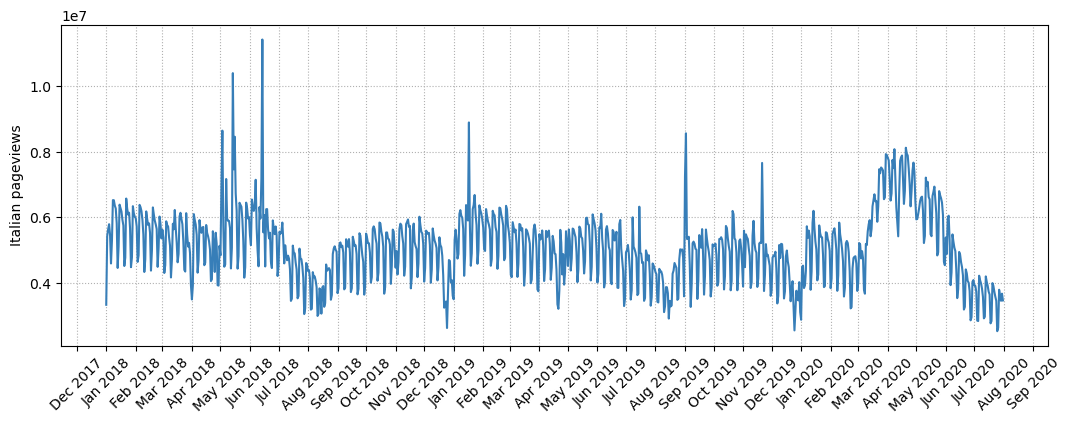

In [151]:
italy = df_timeseries[(df_timeseries.language == 'it') & (df_timeseries.topic == 'ALL')]
fig = plt.figure(constrained_layout=False, figsize=(28,10))
gs = fig.add_gridspec(2, 2, hspace=0.4)
ax = fig.add_subplot(gs[0, 0])

ax.plot(italy.date , italy.pageviews, color="#377eb8", zorder=9)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=45)

ax.set_ylabel("Italian pageviews")

ax.grid(ls=":")

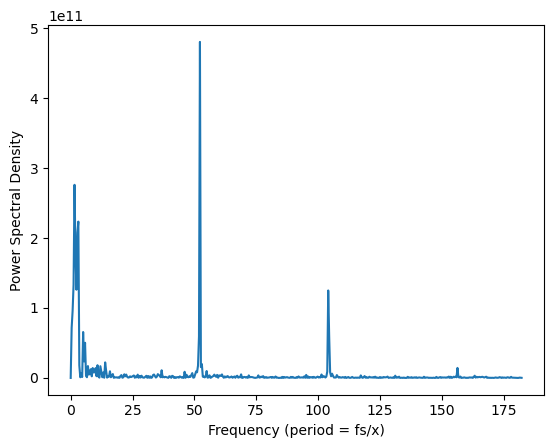

In [152]:
freq, spectrum = periodogram(italy.pageviews, fs=365)
plt.plot(freq,spectrum)
plt.xlabel('Frequency (period = fs/x)')
plt.ylabel('Power Spectral Density')
plt.show()

# There are some weekly patterns -> peak at fs/52 = 7: weekly peak

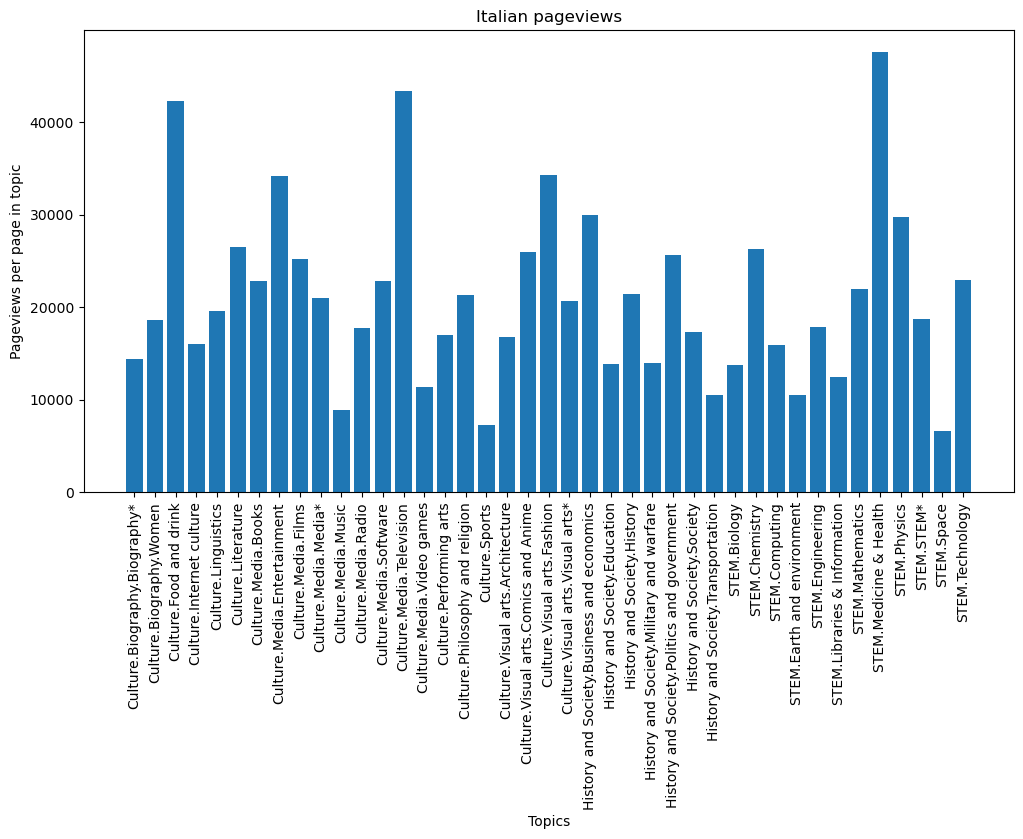

In [153]:
plt.figure(figsize=(12, 6))
plt.bar(topics_df.index, topics_df['it'].values)
plt.xticks(rotation=90)
plt.xlabel('Topics')
plt.ylabel('Pageviews per page in topic')
plt.title('Italian pageviews')
plt.show()

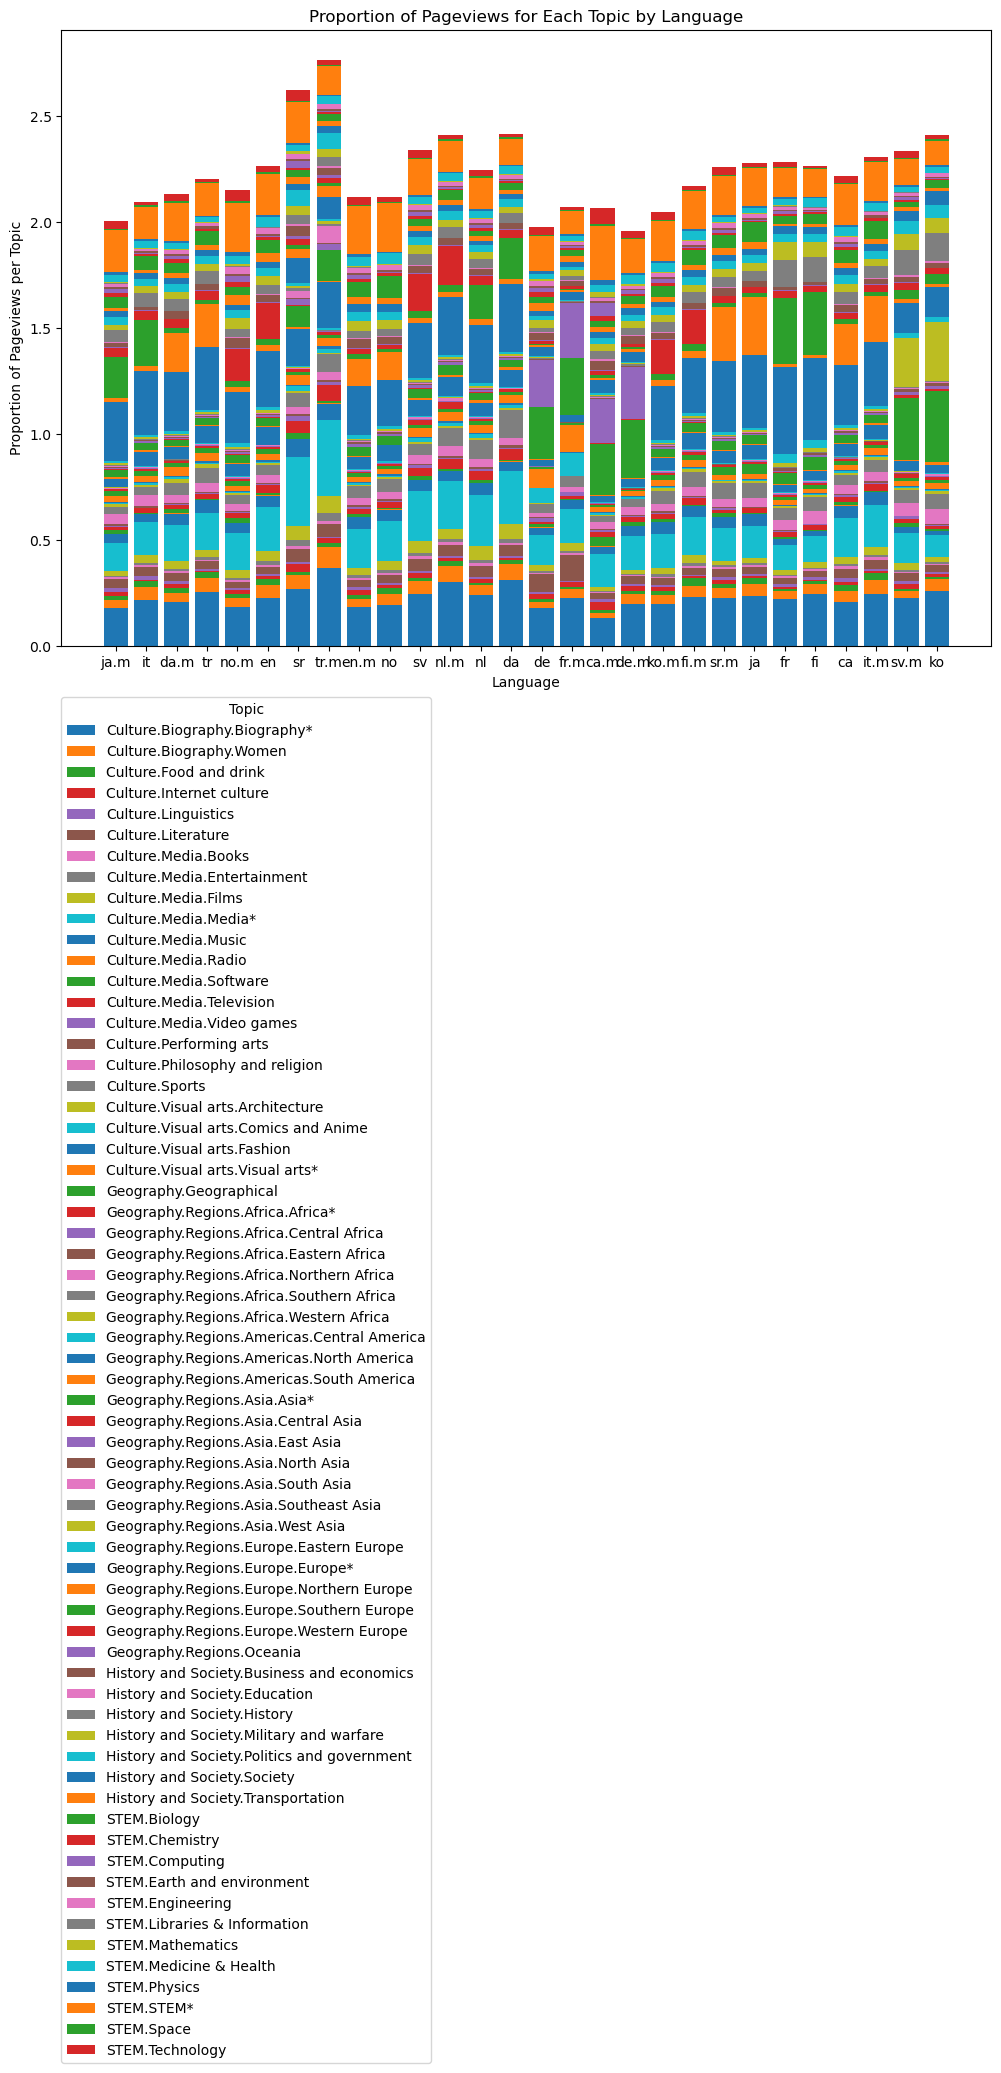

In [154]:
topic_data = {}
grouped = df_timeseries[df_timeseries.topic != 'ALL'].groupby(['language', 'topic'])

for (language, topic), group in grouped:
    topic_data.setdefault(topic, []).append(group['proportion'].values) #/ group['proportion'].sum())

topics = list(topic_data.keys())
bottom = [0] * len(df_timeseries['language'].unique())

plt.figure(figsize=(12, 8))

for i, topic in enumerate(topics):
    heights = list(zip(*topic_data[topic]))
    plt.bar(df_timeseries['language'].unique(), heights[-1], bottom=bottom, label=topic)
    bottom = [sum(x) for x in zip(bottom, heights[-1])]

plt.title('Proportion of Pageviews for Each Topic by Language')
plt.xlabel('Language')
plt.ylabel('Proportion of Pageviews per Topic')
plt.legend(title='Topic', loc=(0,-2.3))
plt.show()

Clusters:
0 ['fr', 'it']
1 ['de', 'fi', 'nl', 'sv']
2 ['ja']
3 ['ca', 'da', 'no', 'sr', 'tr']
4 ['ko']


<Axes: xlabel='topic', ylabel='language'>

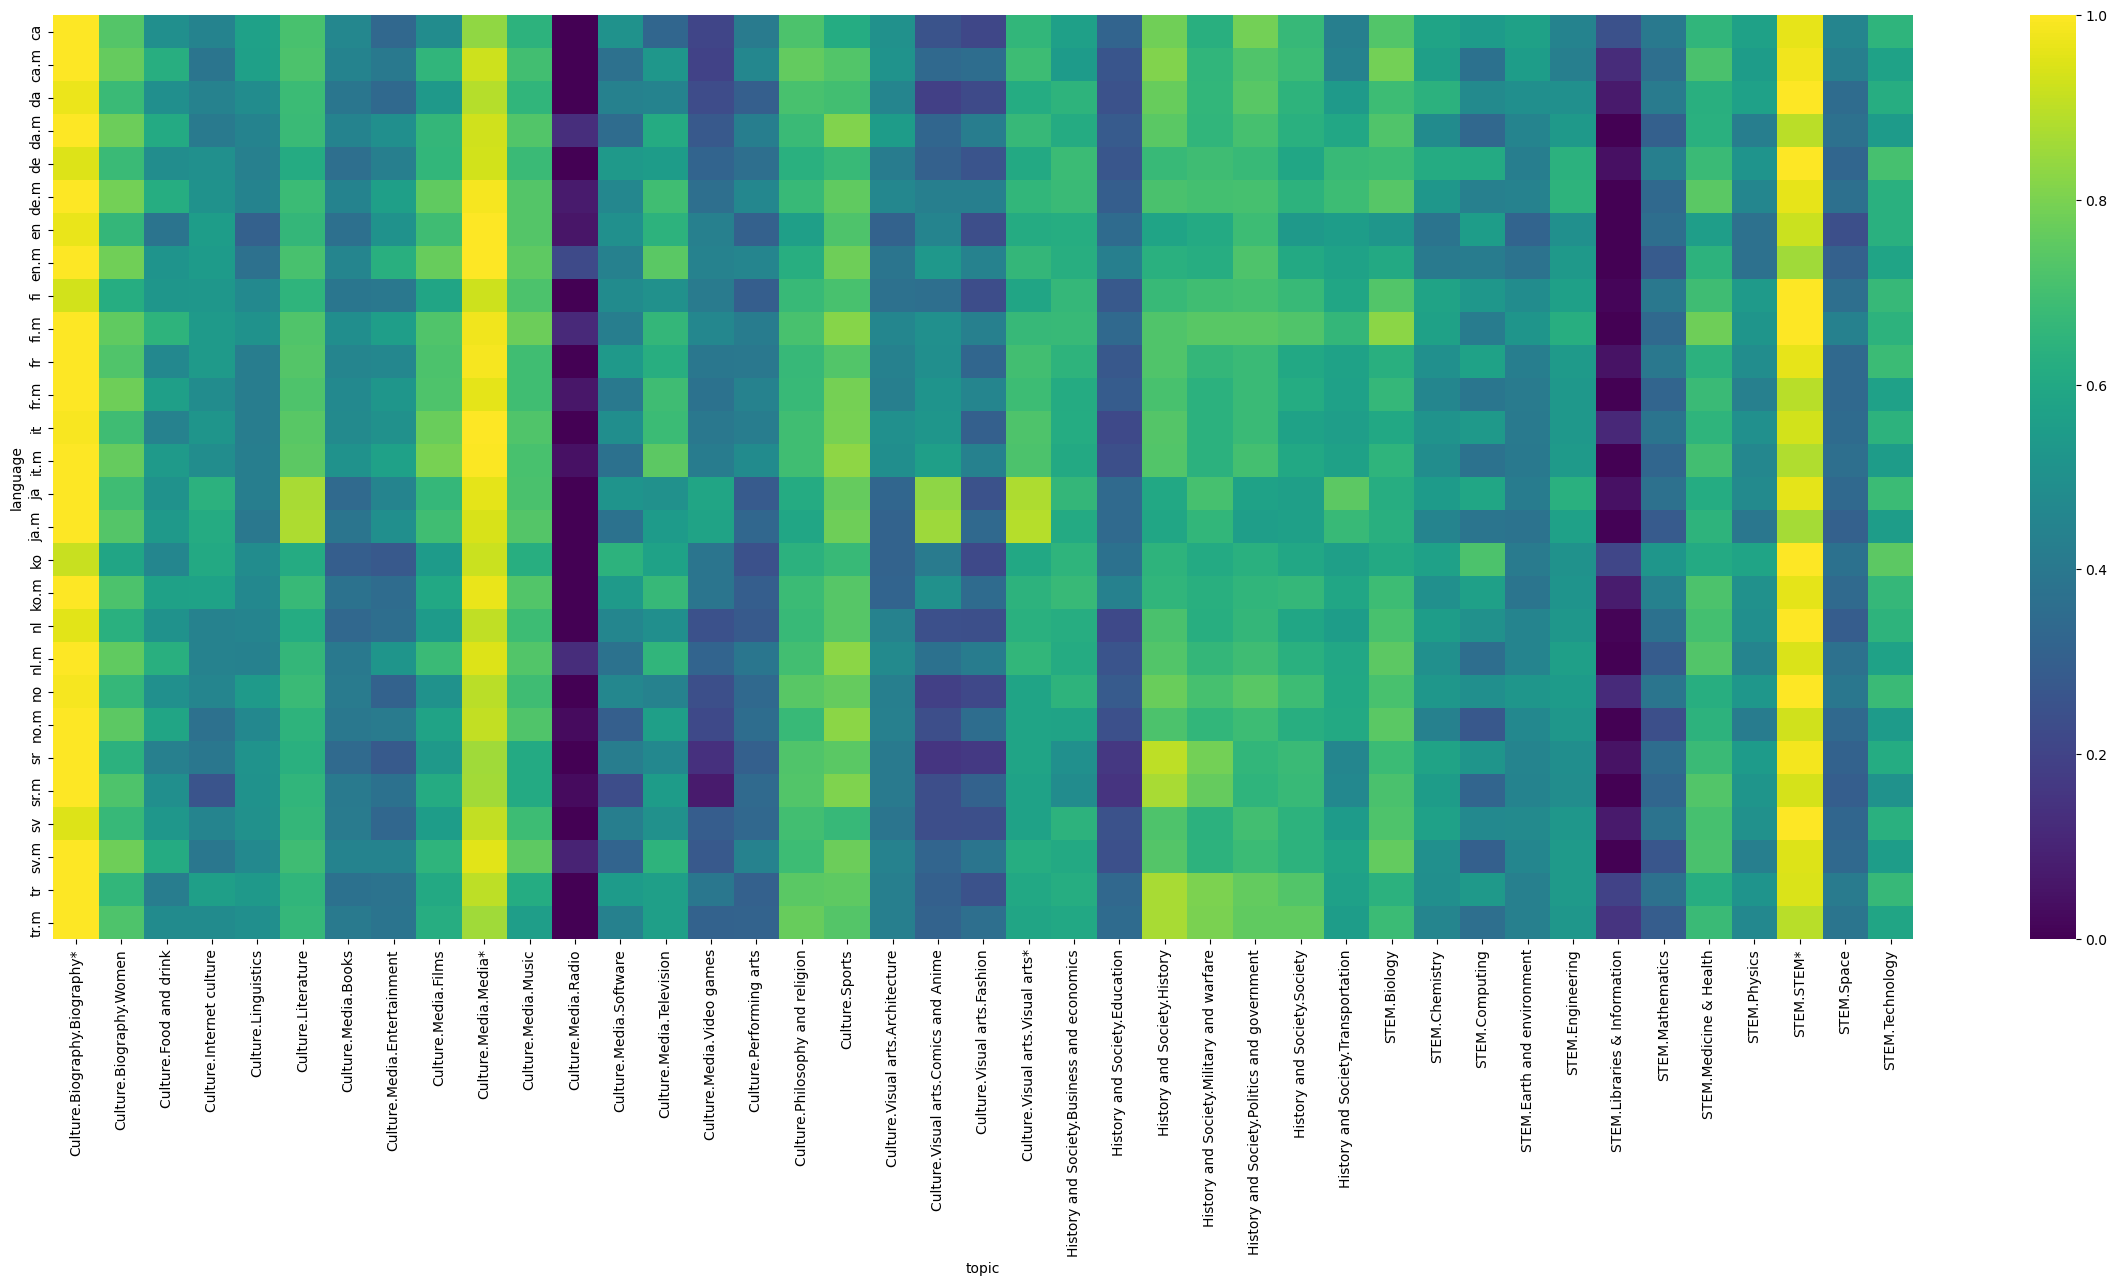

In [102]:
# MinMax normalisation
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

heatmap_df = df_total[(df_total.topic != 'ALL') & (~df_total.topic.str.startswith('Geography'))].pivot(index="topic", columns="language", values="pageviews")
heatmap_df = np.log(heatmap_df)
heatmap_df = (heatmap_df - heatmap_df.min()) / (heatmap_df.max() - heatmap_df.min())

top3 = {}
for lang in heatmap_df.columns:
    top3[lang] = list(heatmap_df.nlargest(3, lang).index)
# print(top3)

df = heatmap_df.filter(regex='.*(?<!\.m)$').T
df = heatmap_df.loc[:,(~heatmap_df.columns.str.endswith('.m')) & (heatmap_df.columns != 'en')].T
kmeans = KMeans(n_clusters=5, n_init='auto')
clusters = kmeans.fit_predict(df)
s = pd.Series(data = clusters, index = df.index)
print('Clusters:')
for val, group in s.groupby(s):
    print(val, list(group.index))

fig, ax = plt.subplots(figsize=(30,12))
sns.heatmap(heatmap_df.T, cmap='viridis', ax=ax)

<Axes: ylabel='ctr'>

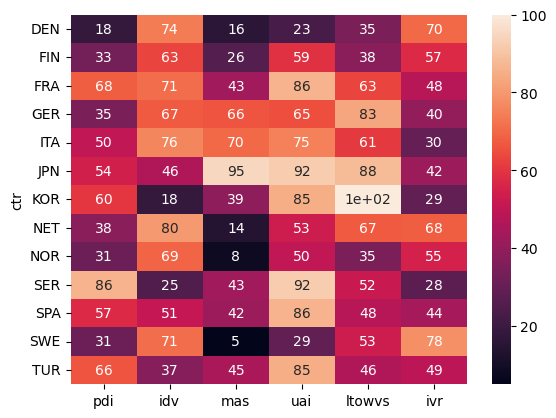

In [91]:
sns.heatmap(hofstede, annot=True)

In [157]:
dbscan = DBSCAN(eps=6, min_samples=1)
for dim in hofstede.columns:
    hofstede['cluster_' + dim] = dbscan.fit_predict(hofstede[[dim]])
hofstede

,pdi,idv,mas,uai,ltowvs,ivr,cluster_pdi,cluster_idv,cluster_mas,cluster_uai,cluster_ltowvs,cluster_ivr
ctr,,,,,,,,,,,,
DEN,18,74,16,23,35,70,0,0,0,0,0,0
FIN,33,63,26,59,38,57,1,0,1,1,0,1
FRA,68,71,43,86,63,48,2,0,2,2,1,1
GER,35,67,66,65,83,40,1,0,3,1,2,1
ITA,50,76,70,75,61,30,2,0,3,3,1,2
JPN,54,46,95,92,88,42,2,1,4,2,2,1
KOR,60,18,39,85,100,29,2,2,2,2,3,2
NET,38,80,14,53,67,68,1,0,0,1,1,0
NOR,31,69,8,50,35,55,1,0,0,1,0,1


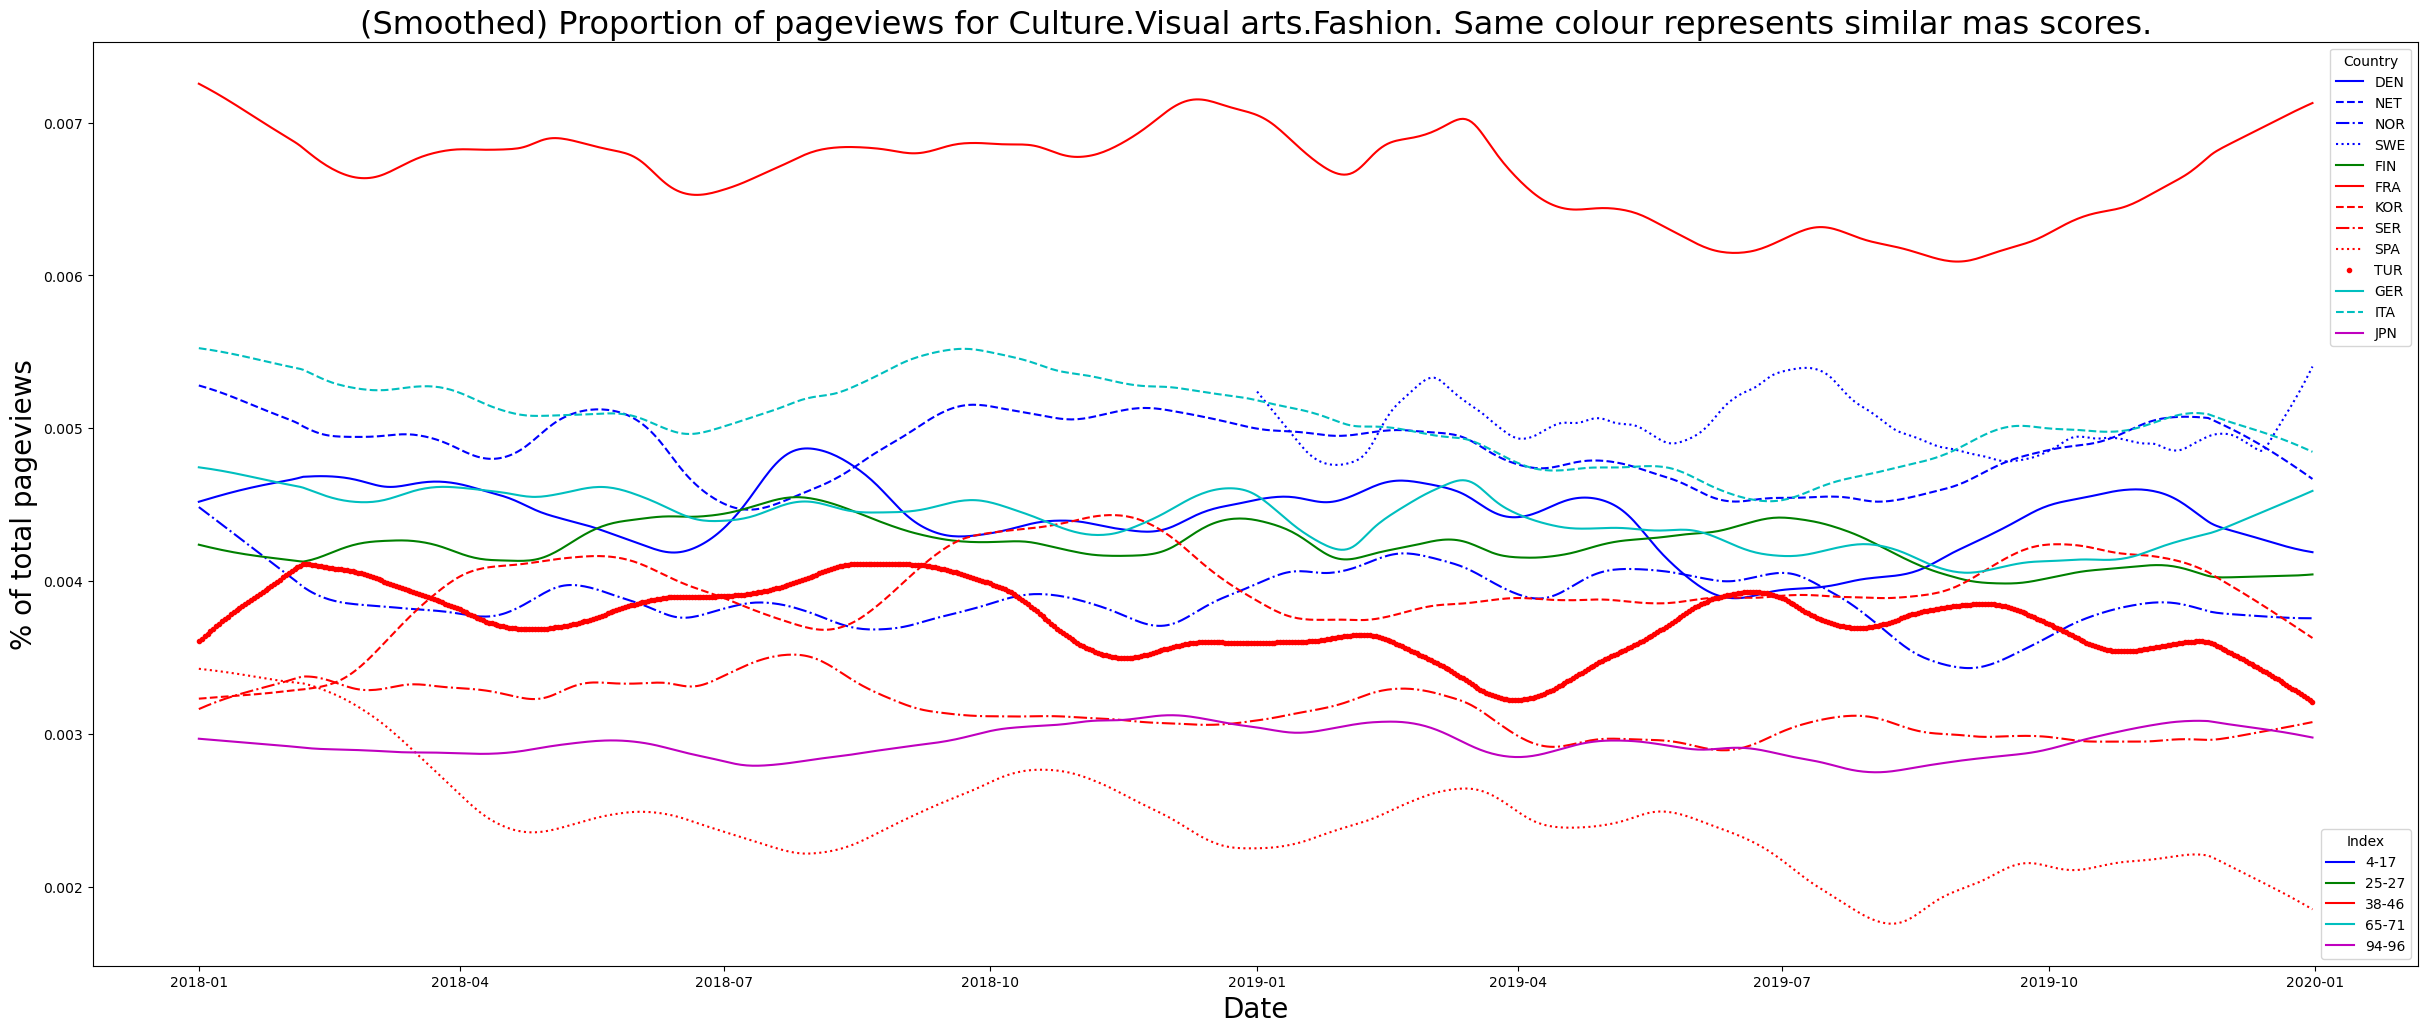

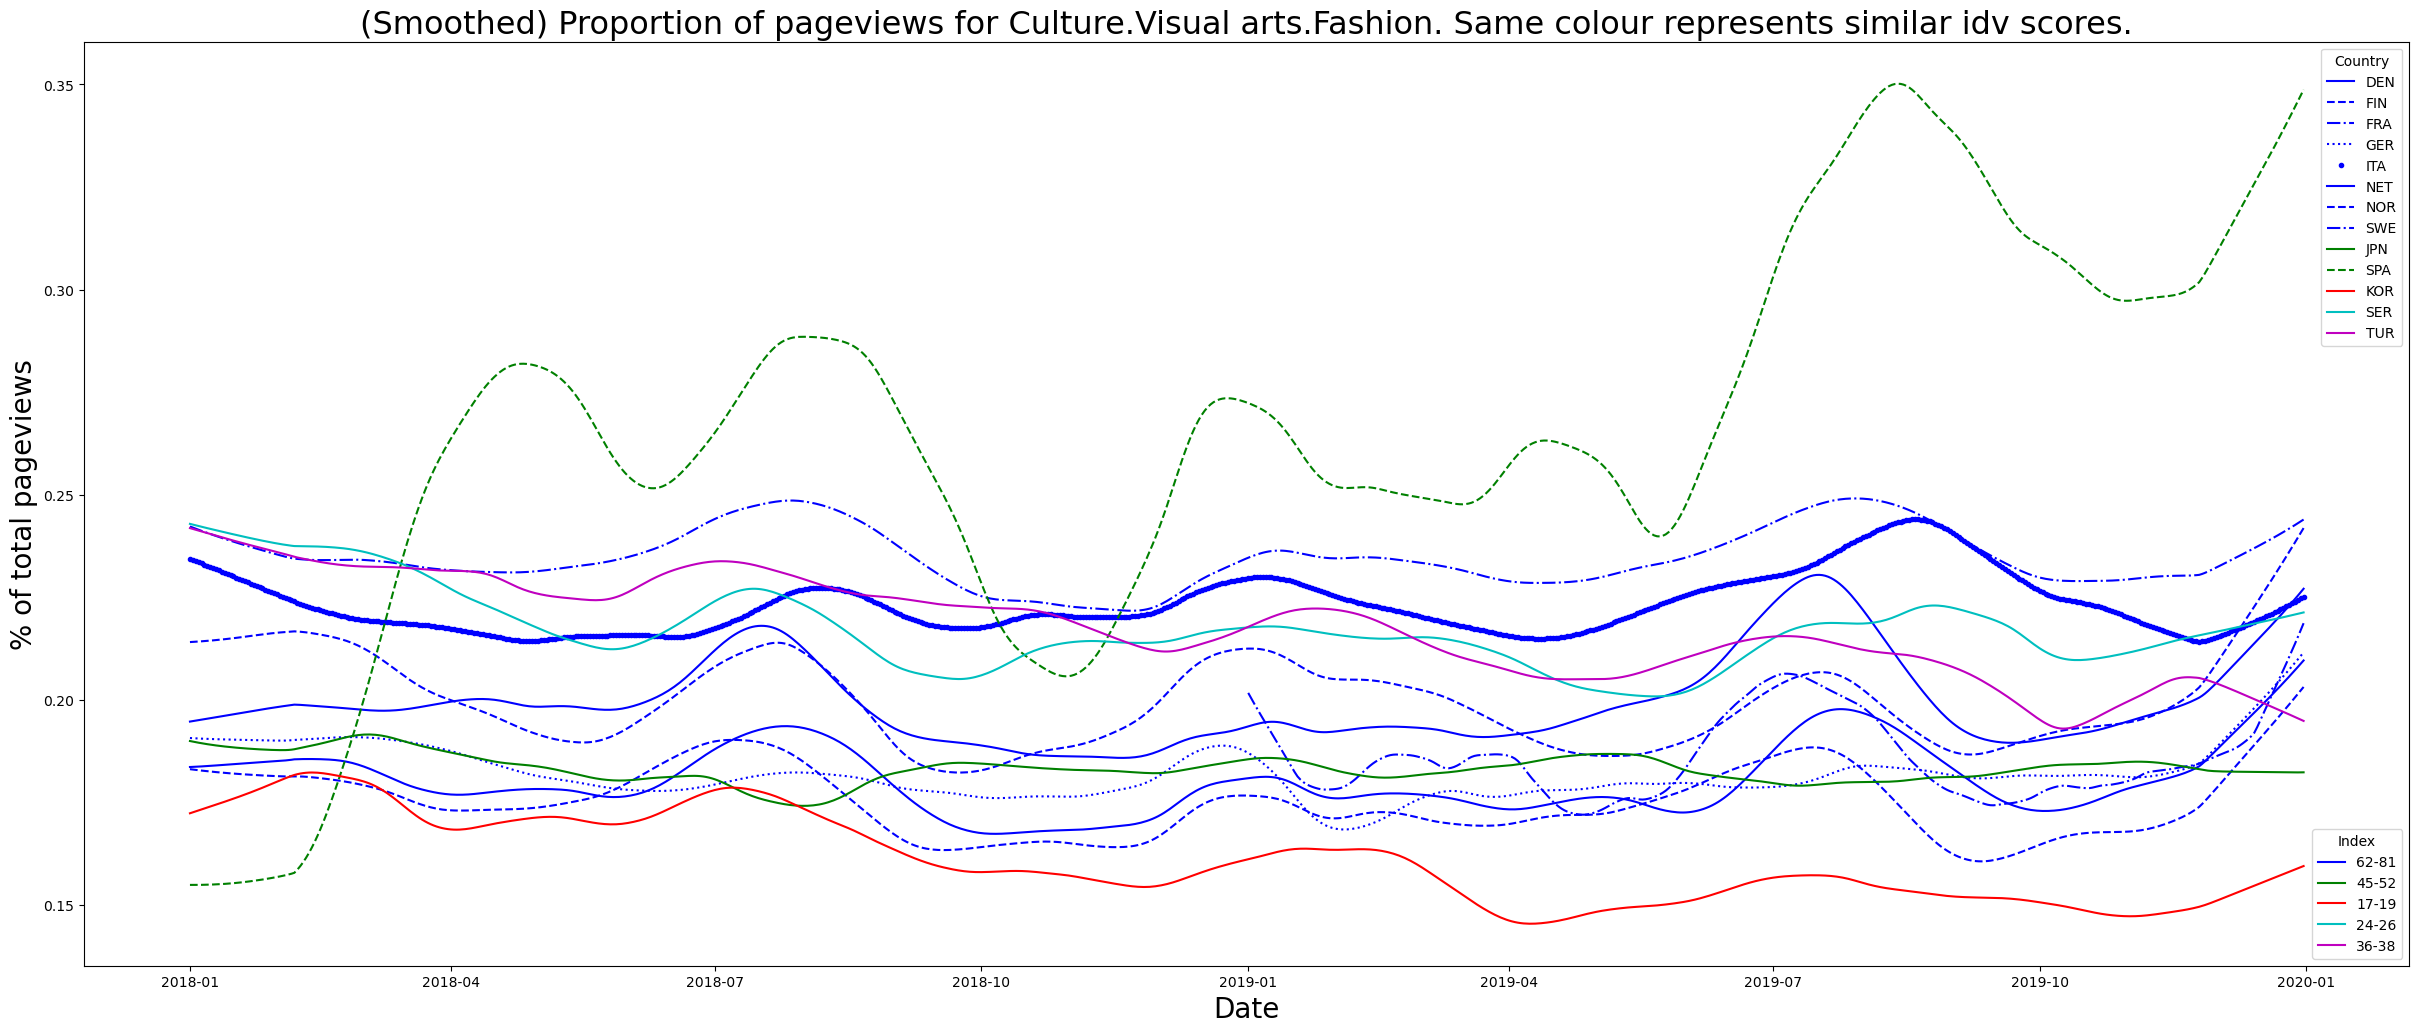

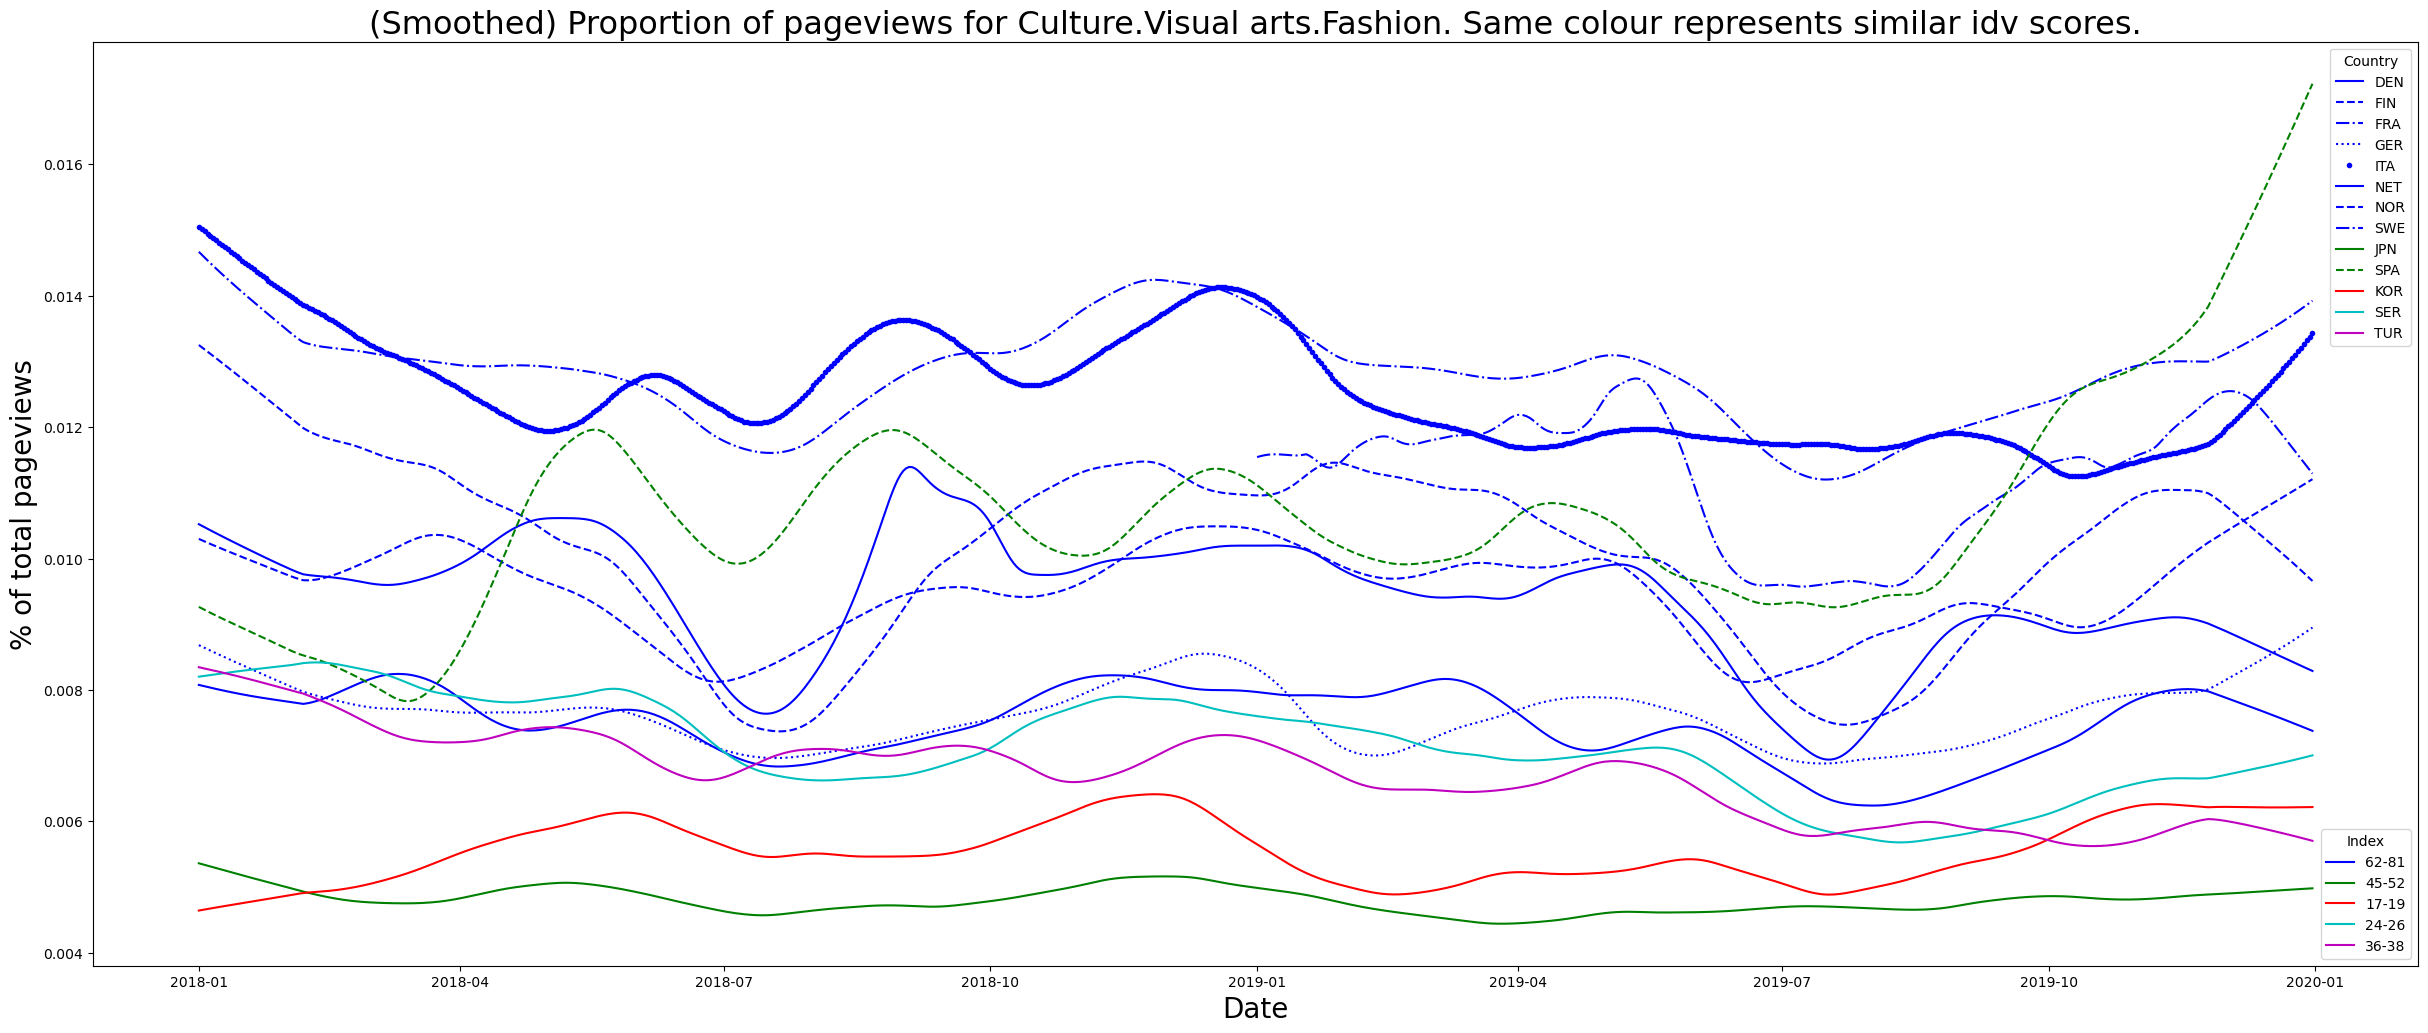

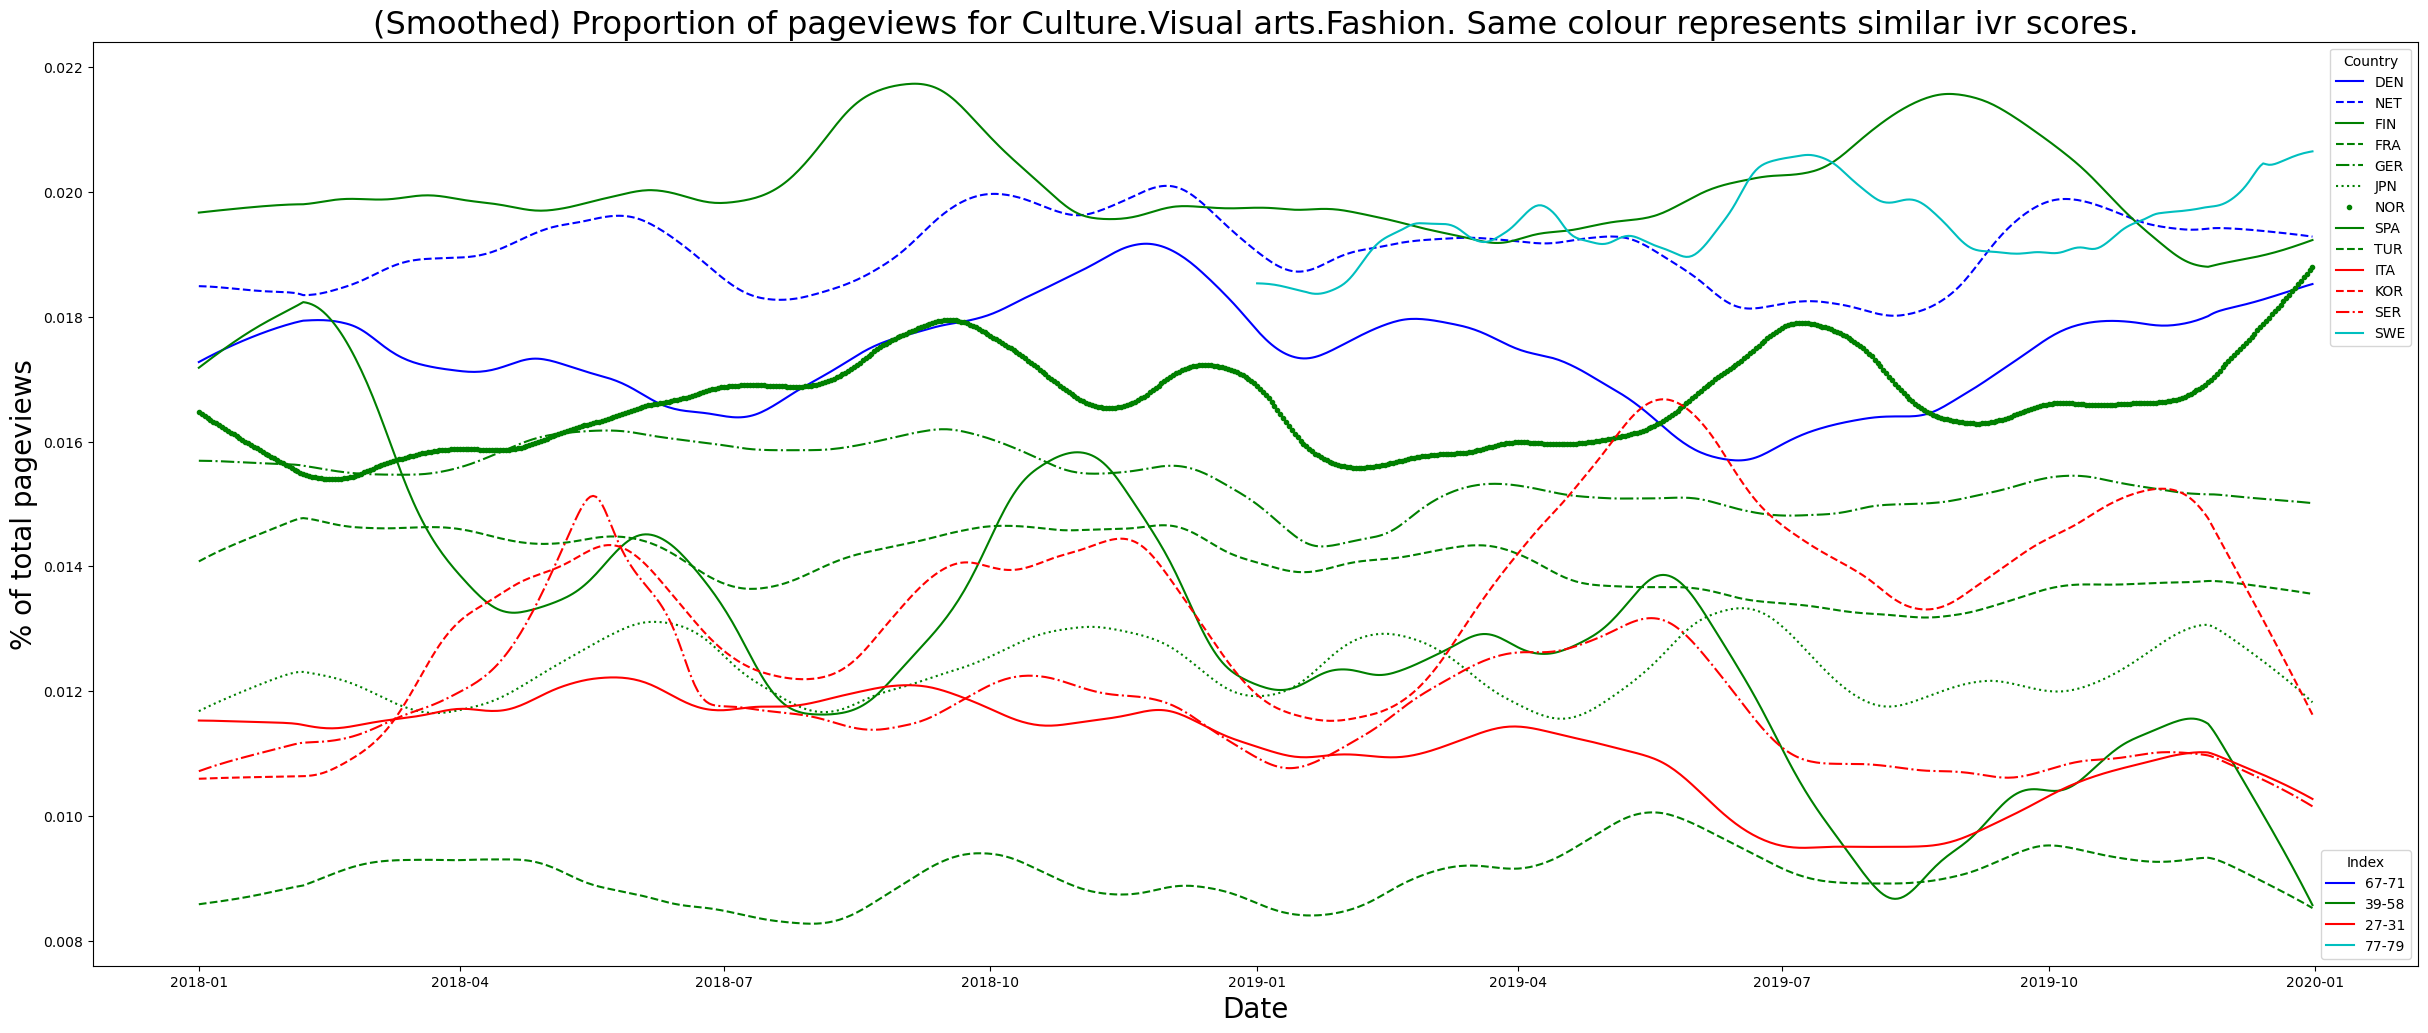

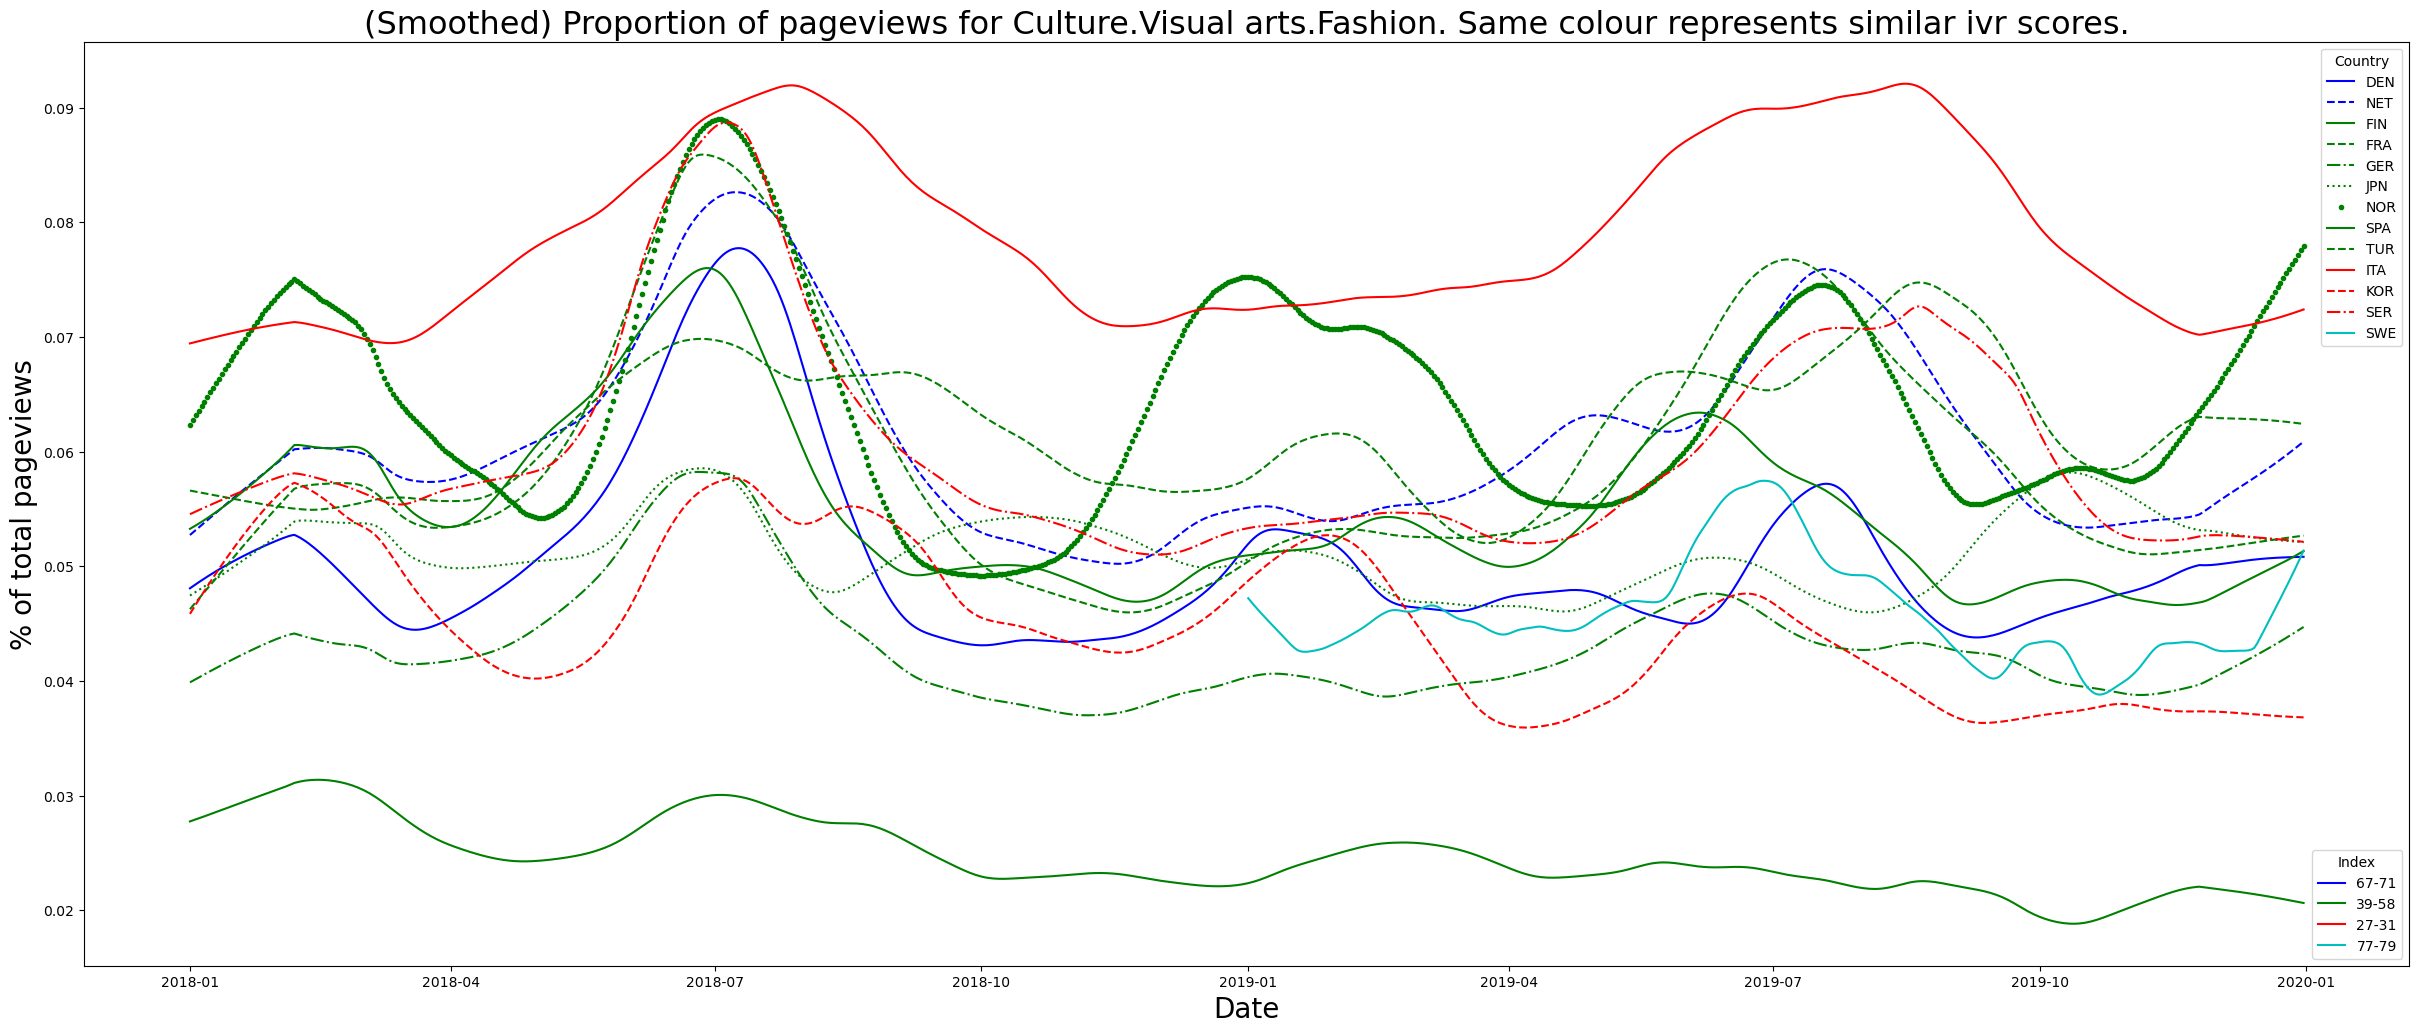

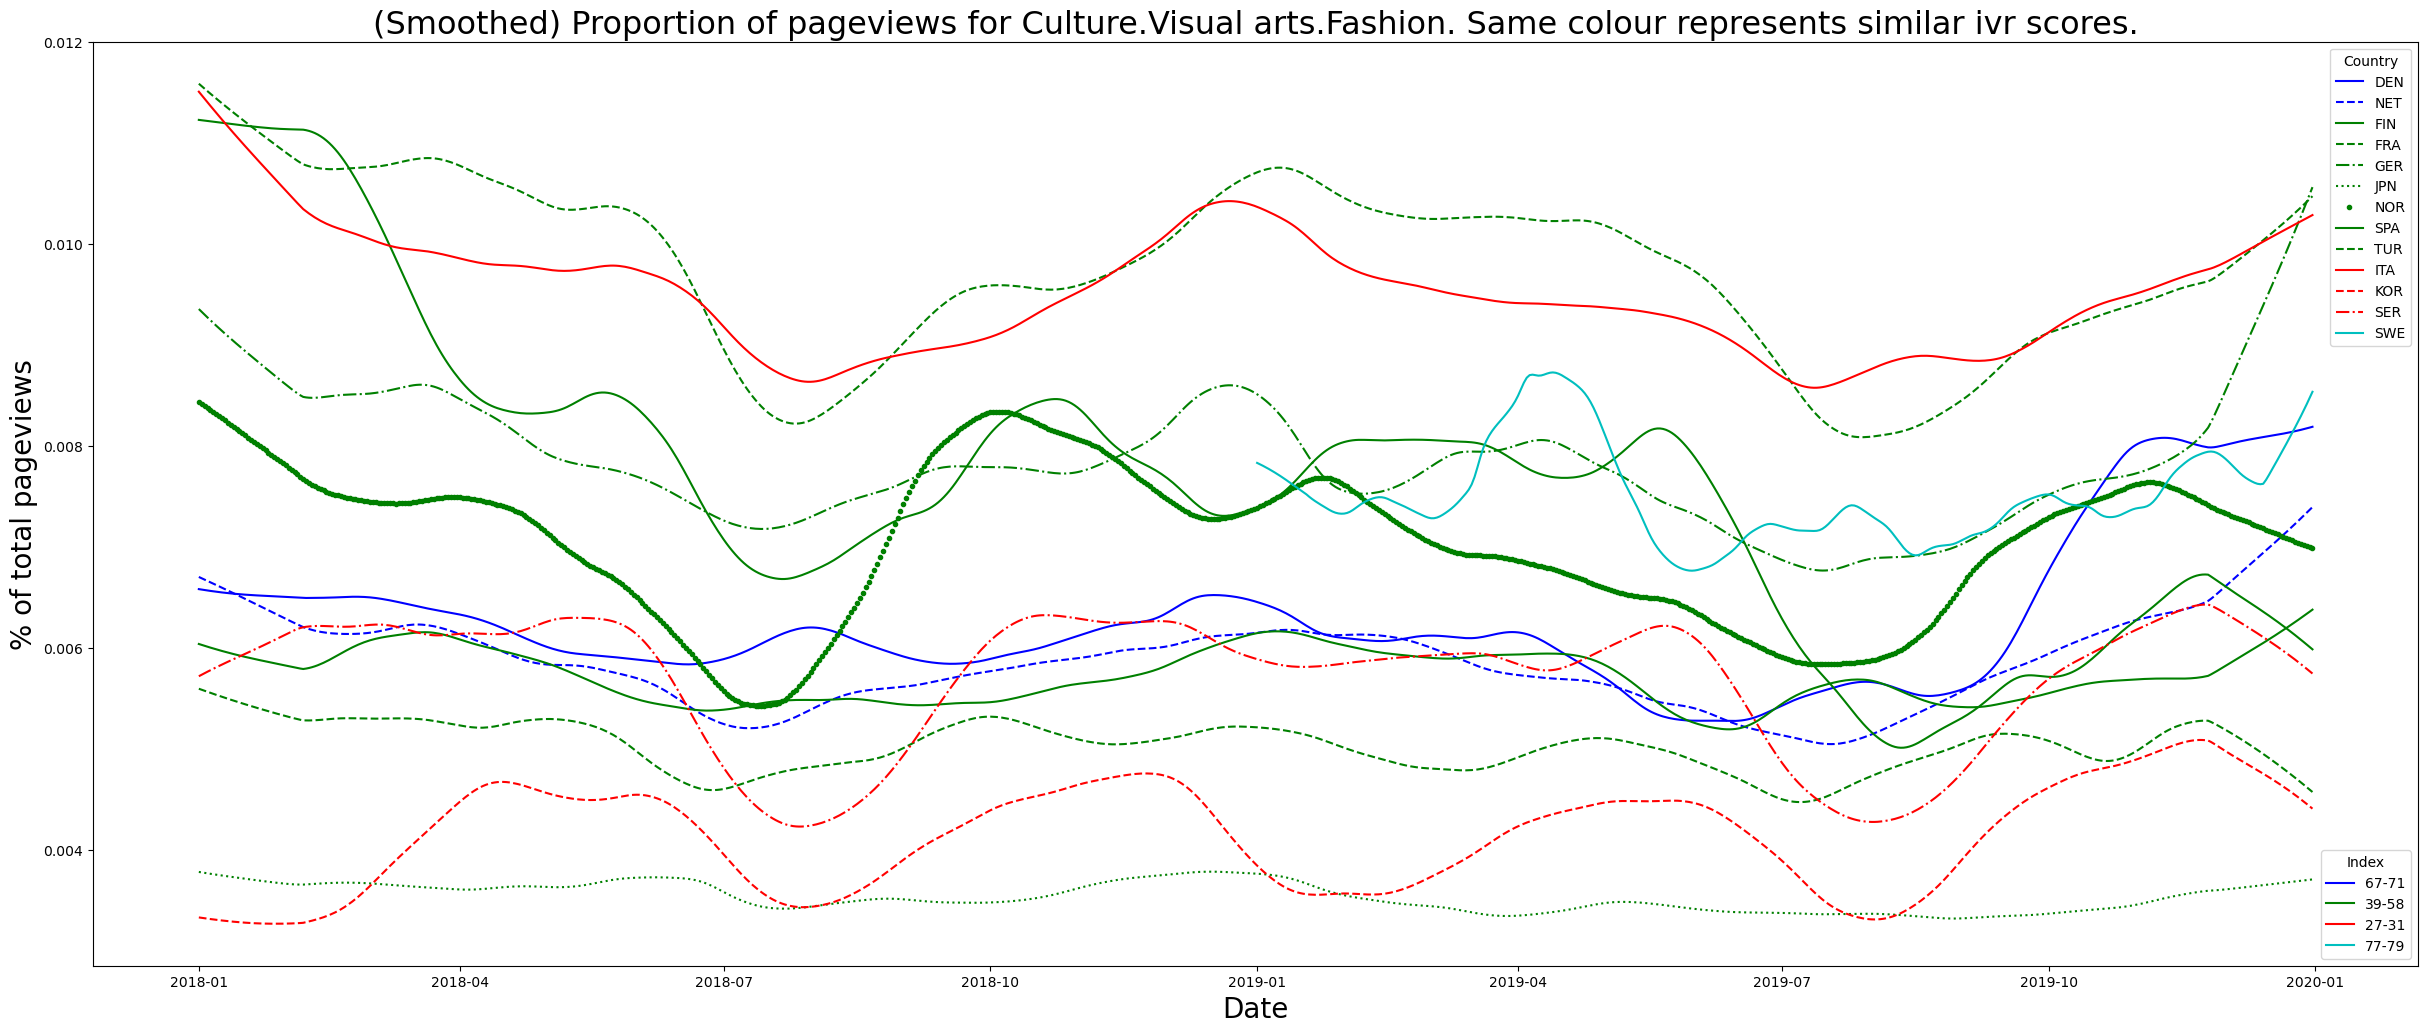

In [158]:
links = {'mas': ['Culture.Visual arts.Fashion'], 
         'idv': ['Culture.Biography.Biography*', 'Culture.Media.Books'], 
         'ivr': ['Culture.Food and drink', 'Culture.Sports', 'Culture.Performing arts']}

colors = ['b', 'g', 'r', 'c', 'm']
dash = ['-', '--', '-.', ':', '.']
d = len(dash)

for dim, ts in links.items():
    for topic in ts:
        df = df_timeseries[(df_timeseries.topic == topic) & (df_timeseries.date.dt.year < 2020)]
        
        _, ax = plt.subplots(figsize=(30,12))
        h1,h2 = [], []
        for i in range(hofstede["cluster_" + dim].max()+1):
            cluster = hofstede[hofstede["cluster_" + dim] == i]
            minval = str(cluster[dim].min() - 1)
            maxval = str(cluster[dim].max() + 1)
            h1.append(ax.plot([],[], colors[i] + '-', label=minval + '-' + maxval)[0])
            for j, cty in enumerate(cluster.index):
                langcode = code_dict[cty]
                dftemp = df[df.language == langcode]
                smooth = lowess(dftemp['proportion'], dftemp.date, frac=0.1)
                h2.append(ax.plot(pd.to_datetime(smooth[:,0]), smooth[:,1], colors[i] + dash[j%d], label=cty)[0])

        leg = ax.legend(handles=h1, loc=4, title="Index")
        ax.add_artist(leg)
        ax.legend(handles=h2, loc=1, title="Country")
        
        ax.set_xlabel('Date', fontsize=20)
        ax.set_ylabel('% of total pageviews', fontsize=20)
        ax.set_title('(Smoothed) Proportion of pageviews for ' + t +'. Same colour represents similar ' + dim + ' scores.', fontsize=23)
plt.show()
